# Face recognition

# 0. Installation des dépendances

In [2]:
# executer cette cellule pour charger l'ensemble des fonctions/librairies utiles
from IPython.core.display import HTML
import requests
#theme_url = "https://raw.githubusercontent.com/ninjasoul/IPython_NB_Config/master/custom.css"
theme_url = "https://raw.githubusercontent.com/ketch/HyperPython/master/custom.css"
rn = requests.get(theme_url)
HTML(rn.text)
from functools import partial
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib notebook
#%matplotlib inline
import pip
pip.main('install imageio'.split())
import imageio
import skimage.morphology
import skimage.segmentation
import skimage.feature


plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.max_open_warning'] = 100
plt.rcParams['figure.figsize'] = 2, 2

def format_coord(x, y, image):
    x = int(x + 0.5)
    y = int(y + 0.5)
    try:
        val = str(image[y, x])
    except IndexError:
        val = "?"
    return "color={} @ [{}, {}]".format(val, y, x)

def display_image_nb(image, title='', cmap=None):
    fig, ax = plt.subplots(1,1)
    if cmap is None:
        ax.matshow(image)
    else:
        ax.matshow(image, cmap=cmap)
    ax.set_xlabel(title)
    ax.format_coord = partial(format_coord, image=image)
    #return fig, ax

def display_image_color(image, title=''):
    fig, ax = plt.subplots(1,1)
    ax.imshow(image)
    ax.set_xlabel(title)
    ax.format_coord = partial(format_coord, image=image)
    #return fig, ax

def draw_rectangle(y1, x1, y2, x2, color='red', ax=None, alpha=1):
    """ Add a rectangle on an image """
    if ax is None:
        ax = plt.gca()
    rect = mpatches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                              fill=False, edgecolor=color, linewidth=2, alpha=alpha)
    ax.add_patch(rect)

print("OK let's go")

OK let's go


# 1. Chargement des jeux de données


## 1.1 Jeu de données de visages

Nous utilisons le jeu de données **Labeled Faces in the Wild Home** (http://vis-www.cs.umass.edu/lfw/).

La fonction fetch_lfw_people du package **sklearn.dataset** permet de télécharger facilement ce jeu de données (aide en ligne disponible ici: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html)


De façon à limiter le nombre d'images nous n'utiliserons que les visages pour lesquels nous disposons de plus de 20 images dans la base.


In [1]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=20, slice_=(slice(69, 69+120), slice(78, 78+100)))
dataset_face = lfw_people.images

- Quelle est la dimension de chaque image ?
- Combien d'images avez vous dans le tableau lfw_people ?
- Affichez une image de la base


In [3]:
len(lfw_people.images)

3023

affichez toutes les images contenant une photo de Bill Clinton (il y en a 29)

## 1.2 Jeu de données "absence de visage"

Nous utilisons des images de type *background*, ne contenant pas de visage. Les images sont disponibles dans le répertoire /negative_image

De façon à obtenir des images de tailles comparables à celles des images de la base visages, nous prétraitons les images. Le code suivant découpe chaque image en sous-images de taille (62 x 47) et créé un tableau contenant toutes ses sous images.

Nous ne gardons que 20000 images dans ce tableau.

In [4]:
import imageio
import glob

max_i = 60
max_j = 50
negative_jpg_files = glob.glob('/negative_image/*.jpg')
negative_dataset = []
for image_file in negative_jpg_files:
    data = imageio.imread(image_file)
    tab = skimage.util.view_as_windows(data, (max_i, max_j), 100)
    for i in range(tab.shape[0]):
        for j in range(tab.shape[1]):
            if len(negative_dataset) < 20000:
                negative_dataset.append(tab[i,j])
    if len(negative_dataset) > 20000:
        break
negative_dataset = np.array(negative_dataset)

print(negative_dataset.shape)

(20000, 60, 50)


 - afficher 5 images du tableau negative_dataset

 De façon à avoir le même nombre d'image dans la base visages et dans la bases 'absence de visages' nous sélectionnons un sous ensemble des images de façon aléatoires dans le tableau negative_dataset. 

<IPython.core.display.Javascript object>


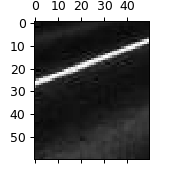

(60, 50)


In [5]:
indexes = np.random.choice(negative_dataset.shape[0], len(lfw_people.images))
dataset_no_face = negative_dataset[indexes, :, :]
display_image_nb(dataset_no_face[1000])
print(dataset_no_face[1000].shape)

In [6]:
dataset_no_face.shape

(3023, 60, 50)

# 2. Extraction de features

La fonction compute_feature_vect permet d'extraire pour une image les histogrames des local binary pattern. Les différents histogrames sont concaténés dans un vecteur.

<img src="http://srand.fr/lbp_histogram.png">


Lire le papier (section LBP): http://cs229.stanford.edu/proj2008/Jo-FaceDetectionUsingLBPfeatures.pdf


# Expliquez briévement ce qui est décrit dans le papier

In [7]:
from skimage.feature import local_binary_pattern
def compute_feature_vect(image, debug=False):
    radius = 2
    n_points = 8 * radius
    METHOD = 'uniform'
    lbp = local_binary_pattern(image, n_points, radius, METHOD)
    n_bins = 18
    hists = []
    if debug:
        display_image_nb(image)
    I = image.shape[0] / 6
    J = image.shape[1] / 5
    step = 10
    tab = skimage.util.view_as_blocks(lbp, (I, J))
    #tab = skimage.util.view_as_windows(lbp, (I,J), step=step)
    c = 0
    colors = ['blue', 'green', 'red']
    for i in range(tab.shape[0]):
        for j in range(tab.shape[1]):
            c+=1
            sub = tab[i, j]
            hist, _ = np.histogram(sub, normed=True, bins=n_bins, range=(0, n_bins))
            hists.append(hist.flatten())
            if debug:
                draw_rectangle(i*step, j*step, i*step+I-1, j*step+J-1, color=colors[c%len(colors)], alpha=0.8)
    return np.array(hists).flatten()


<IPython.core.display.Javascript object>


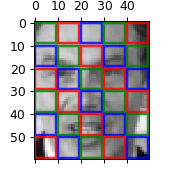

/root/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:482: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


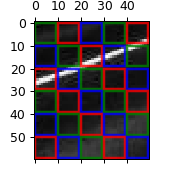

In [25]:
a = compute_feature_vect(dataset_face[1000], debug=True)
b = compute_feature_vect(dataset_no_face[1000], debug=True)

In [9]:
print(a.shape)

(540,)


# 3. Apprentissage

Dans cette section nous utiliserons la librairie python sklearn, comme lors du tp2.



Nous allons créer une liste X de "features" associé à chaque image et une liste Y de labels associés à ses images.

Pour chaque image du jeu de données dataset_face nous associeront le label 'face'
Pour chaque image du jeu de données dataset_noface nous associeront le label 'noface'

Créez ces deux listes (vous pouvez vous aidez de la fonction append ainsi que d'une boucle for)

In [372]:
# en utilisant une boucle for

X = []
Y = []
for image in  `à remplacer`:
    X.append(compute_feature_vect(image))
    #Y.append('à remplacer')
    Y.append()
    
for image in `à remplacer`:
    X.append(compute_feature_vect(image))
    Y.append('à remplacer')
print(len(X))
print(len(Y))

SyntaxError: invalid syntax (<ipython-input-372-067407fdd23d>, line 5)

In [10]:
X = []
Y = []
for image in dataset_face:
    X.append( compute_feature_vect(image))
    Y.append('face')
for image in dataset_no_face:
    X.append(compute_feature_vect(image))
    Y.append('noface')
print(len(Y))


/root/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:482: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return array(a, dtype, copy=False, order=order)


6046


Créez un classifieur de type k-nearest neighbors, avec k = 10

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
clf = KNeighborsClassifier()

# complétez ici:


/root/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Utilisez la fonction cross_val_score afin d'évaluer le taux de bonne reconnaissance.

Le code suivant permet de partitionner le jeu de donnée en un ensemble de test et un ensemble d'entrainement. 
Le classifieur est alors entrainé à reconnaitre chaque classe (visage vs. absence de visage) sur le jeu d'entrainement (méthode fit).

Nous affichons ensuite le score obtenu sur le jeu de test, ainsi que la matrice de confusion associé.



In [12]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0, test_size=0.1)

clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

prediction_on_testing_data = clf.predict(X_test)
print(confusion_matrix(y_test, prediction_on_testing_data))

0.955371900826
[[290   0]
 [ 27 288]]


Expliquez à quoi correspondent les nombres dans la matrices de confusions.


Entrainez une nouvelle fois le classifieur mais cette fois en utilisant l'ensemble du jeu de donnée.


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform')

In [322]:
# entrainez un second classifieur de type adaboost


In [324]:
from sklearn.ensemble import AdaBoostClassifier

clf2 = # acompléter

SyntaxError: invalid syntax (<ipython-input-324-512c3e291843>, line 3)

Expliquez en quelques phrases ce que vous avez fait jusqu'à présent dans ce tp, quels classifieur avez vous entrainez, comment, qu'est ce qu'ils permettent de faire, avec quelles performances etc.


...

# 4. Détection de visage 

La fonction check_image vous permet de parcourir à l'aide d'une fenêtre glissante une image de test, et entoure en vert tous les visages détectés

In [18]:

def check_image(image_test, window_size = (60, 50), clf=clf):
    STEP = max(window_size) /3
    tab = skimage.util.view_as_windows(image_test, window_size, STEP)
    display_image_nb(image_test)
    for i in range(tab.shape[0]):
        for j in range(tab.shape[1]):
            block = tab[i, j]
            features = compute_feature_vect(block)
            prediction = clf.predict(features.flatten().reshape(1, -1))
            #print(prediction)
            if prediction == 'face':
                draw_rectangle(i*STEP, j*STEP, i*STEP+window_size[0], j*STEP+window_size[1], color='green')

            #if prediction != 'face':
             #   draw_rectangle(i*STEP, j*STEP, i*STEP+window_size[0], j*STEP+window_size[1], color='red')
                #display_image_nb(block)
            
        

In [19]:
image_test = skimage.color.rgb2gray(imageio.imread("/images/ABBA_-_TopPop_1974_5.png"))


/root/anaconda3/lib/python3.6/site-packages/skimage/util/shape.py:255: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  indexing_strides = arr_in[slices].strides
/root/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:482: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


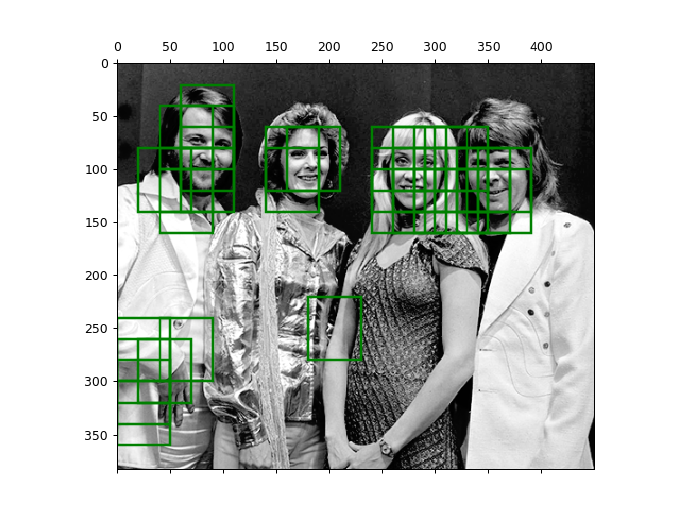

In [20]:

abba = skimage.transform.rescale(image_test, 0.9)
check_image(abba)
#check_image(abba, clf=clf2)

/root/anaconda3/lib/python3.6/site-packages/skimage/util/shape.py:255: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  indexing_strides = arr_in[slices].strides
/root/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:482: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


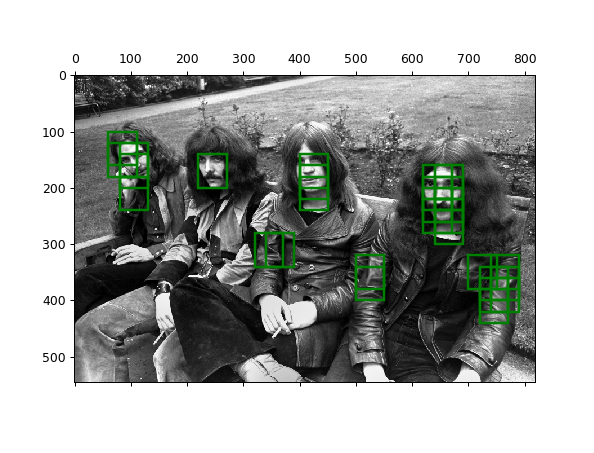

In [17]:
img_test = "/images/black-sabbath-1970.jpg"
image = skimage.color.rgb2gray(imageio.imread(img_test))
image = skimage.transform.rescale(image, 0.4)
check_image(image, clf=clf)

/home/seto/anaconda3/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 100 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


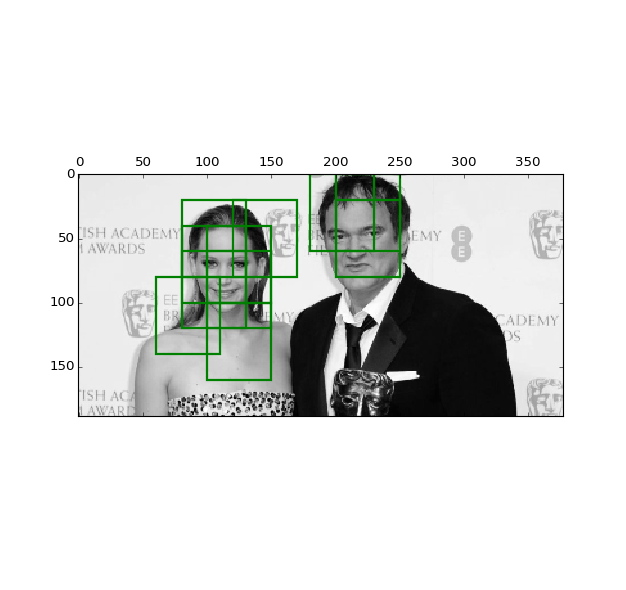

Testez la méthode sur 10 images (smartphone, ou sur le net). Pensez a utilisez la fonction rescale comme illustrez dans les exemples précédents, afin d'avoir une fenêtre d'analyse a peu près égale à la taille des visages présents dans l'image.

Quelles sont les limites du système ?
Que proposez vous pour y remédier ? 


# Utilisez Opencv pour détecter les visages

La librairie OpenCV fourni un classifieur déjà entrainé pour détecter des visages et des yeux. 
suivez le tutoriel disponnible ici http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html pour utiliser cette detection sur les images précédentes.


In [53]:
 
import cv2
face_cascade = cv2.CascadeClassifier("/root/anaconda3/share/OpenCV/haarcascades/haarcascade_frontalcatface_extended.xml")
eye_cascade = cv2.CascadeClassifier("/root/anaconda3/share/OpenCV/haarcascades/haarcascade_eye_tree_eyeglasses.xml")

# Complétez !
